## Introduction

In this notebook, we delve into evaluation of different classification models used for classifying Fake News.

To tackle this challenge, we explore both traditional machine learning and deep learning techniques. We employ Logistic Regression, Naive Bayes, and Random Forest as representatives from the domain of traditional machine learning. Alongside these, we also utilize Recurrent Neural Networks (RNN), a potent tool from the deep learning toolbox, known for their effectiveness in handling sequential data.

Logistic Regression and Naive Bayes serve as our baseline models, given their simplicity and ease of interpretability. Random Forest, an ensemble learning method, provides us with a more sophisticated and robust model, leveraging multiple decision trees to yield a potentially more accurate and generalized prediction.

The Recurrent Neural Network, on the other hand, is a more complex and powerful model that can capture temporal dynamics and dependencies in data, making it suitable for data where order matters. For our task, this model might capture more complex patterns and hence deliver superior performance.

To evaluate the performance of these models, we focus on two key metrics - Accuracy and Area Under the Receiver Operating Characteristic (AUROC). While accuracy gives us a straightforward measure of a model's performance, AUROC provides an aggregate measure of performance across all possible classification thresholds. This is particularly useful in scenarios where we have imbalanced classes or the cost of misclassification varies across classes.

After building and training our models, we consolidate their performance metrics in a Pandas DataFrame. This tabular format allows for easy comparison and analysis of the models' performances. Additionally, we also visualize the Receiver Operating Characteristic (ROC) curves of the models. These plots not only allow us to see the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR) at different thresholds but also give us another visual means to compare the performances of our models.

In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Mouting the google drive to google collaboratory
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Read the CSV file from the preprocessing step
news_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train_processed.csv', encoding='UTF-8')

In [4]:
# Split the data into train, validation, and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(news_df['clean_joined'], news_df['label'], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [5]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)
# Transform the validation data
X_val_tfidf = vectorizer.transform(X_val)
# Transform the test data
X_test_tfidf = vectorizer.transform(X_test)

In [6]:
with open('/content/gdrive/MyDrive/Colab Notebooks/logreg_model.pkl', 'rb') as file:
    logreg_model = pickle.load(file)

with open('/content/gdrive/MyDrive/Colab Notebooks/naivebayes_model.pkl', 'rb') as file:
    naivebayes_model = pickle.load(file)

with open('/content/gdrive/MyDrive/Colab Notebooks/randomforest_model.pkl', 'rb') as file:
    randomforest_model = pickle.load(file)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your ow

In [7]:
def evaluate_model(model, X, y, model_name, data_name):
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    metrics = {'Model': model_name,
               'Data': data_name,
               'Accuracy': accuracy,
               'Precision': precision,
               'Recall': recall,
               'F1-Score': f1}

    return pd.DataFrame(metrics, index=[0])

In [8]:
# Load the RNN model
rnn_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/rnn_model.h5')

# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = 170784)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [9]:
padded_train = pad_sequences(train_sequences,maxlen = 4000, padding = 'post', truncating = 'post')
padded_val = pad_sequences(val_sequences,maxlen = 4000,  padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 4000,  padding = 'post', truncating = 'post')

pred_train = rnn_model.predict(padded_train)
pred_test = rnn_model.predict(padded_test)
pred_val = rnn_model.predict(padded_val)

117/117 [==============================] - 11s 91ms/step


In [10]:
def rnn_evaluate_model(y, y_pred, model_name, data_name):

    accuracy = accuracy_score(list(y), y_pred)
    precision = precision_score(list(y), y_pred)
    recall = recall_score(list(y), y_pred)
    f1 = f1_score(list(y), y_pred)

    metrics = {'Model': model_name,
               'Data': data_name,
               'Accuracy': accuracy,
               'Precision': precision,
               'Recall': recall,
               'F1-Score': f1}

    return pd.DataFrame(metrics, index=[0])

In [11]:
# if the predicted value is >0.5 it is real else it is fake
def prob_to_bin(pred_prob):
  prediction = []
  for i in range(len(pred_prob)):
      if pred_prob[i].item() > 0.5:
          prediction.append(1)
      else:
          prediction.append(0)
  return prediction

#accuracy = accuracy_score(list(y_test), prediction_test)


In [12]:
pred_train_bin = prob_to_bin(pred_train)
pred_val_bin = prob_to_bin(pred_val)
pred_test_bin = prob_to_bin(pred_test)

In [13]:
results = pd.concat([
    evaluate_model(logreg_model, X_train_tfidf, y_train, 'Logistic Regression', 'Train'),
    evaluate_model(logreg_model, X_val_tfidf, y_val, 'Logistic Regression', 'Validation'),
    evaluate_model(logreg_model, X_test_tfidf, y_test, 'Logistic Regression', 'Test'),

    evaluate_model(naivebayes_model, X_train_tfidf, y_train, 'Naive Bayes', 'Train'),
    evaluate_model(naivebayes_model, X_val_tfidf, y_val, 'Naive Bayes', 'Validation'),
    evaluate_model(naivebayes_model, X_test_tfidf, y_test, 'Naive Bayes', 'Test'),

    evaluate_model(randomforest_model, X_train_tfidf, y_train, 'Random Forest', 'Train'),
    evaluate_model(randomforest_model, X_val_tfidf, y_val, 'Random Forest', 'Validation'),
    evaluate_model(randomforest_model, X_test_tfidf, y_test, 'Random Forest', 'Test'),

    rnn_evaluate_model(y_train, pred_train_bin, 'Recurrent Neural Network', 'Train'),
    rnn_evaluate_model(y_val, pred_val_bin, 'Recurrent Neural Network', 'Validation'),
    rnn_evaluate_model(y_test, pred_test_bin, 'Recurrent Neural Network', 'Test'),
], ignore_index=True)

print(results)

                       Model        Data  Accuracy  Precision    Recall  \
0        Logistic Regression       Train  1.000000   1.000000  1.000000   
1        Logistic Regression  Validation  0.959326   0.959563  0.957470   
2        Logistic Regression        Test  0.960501   0.965551  0.954280   
3                Naive Bayes       Train  0.895885   0.990443  0.800506   
4                Naive Bayes  Validation  0.864330   0.979754  0.738822   
5                Naive Bayes        Test  0.853565   0.986559  0.714008   
6              Random Forest       Train  1.000000   1.000000  1.000000   
7              Random Forest  Validation  0.935510   0.951275  0.915485   
8              Random Forest        Test  0.936898   0.960946  0.909533   
9   Recurrent Neural Network       Train  0.994045   0.990352  0.997869   
10  Recurrent Neural Network  Validation  0.964410   0.948813  0.980371   
11  Recurrent Neural Network        Test  0.959056   0.938605  0.981518   

    F1-Score  
0   1.000

In [14]:
results

,Model,Data,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,Train,1.000000,1.000000,1.000000,1.000000
1,Logistic Regression,Validation,0.959326,0.959563,0.957470,0.958515
2,Logistic Regression,Test,0.960501,0.965551,0.954280,0.959883
3,Naive Bayes,Train,0.895885,0.990443,0.800506,0.885403
4,Naive Bayes,Validation,0.864330,0.979754,0.738822,0.842400
5,Naive Bayes,Test,0.853565,0.986559,0.714008,0.828442
6,Random Forest,Train,1.000000,1.000000,1.000000,1.000000
7,Random Forest,Validation,0.935510,0.951275,0.915485,0.933037
8,Random Forest,Test,0.936898,0.960946,0.909533,0.934533
9,Recurrent Neural Network,Train,0.994045,0.990352,0.997869,0.994096


import numpy as np
from google.colab import autoviz
df_1240750518812523678 = autoviz.get_df('df_1240750518812523678')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_1240750518812523678, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2271618340412433818 = autoviz.get_df('df_2271618340412433818')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_2271618340412433818, *['Precision'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8648815184051625273 = autoviz.get_df('df_8648815184051625273')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8648815184051625273, *['Recall'], **{})
chart

import numpy as np
from google.colab import autoviz
df_269550481058577355 = autoviz.get_df('df_269550481058577355')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_269550481058577355, *['F1-Score'], **{})
chart

import numpy as np
from google.colab import autoviz
df_261119930605420202 = autoviz.get_df('df_261119930605420202')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_261119930605420202, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6441230527264306943 = autoviz.get_df('df_6441230527264306943')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_6441230527264306943, *['Precision'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7282122128016981879 = autoviz.get_df('df_7282122128016981879')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_7282122128016981879, *['Recall'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4854025519112535220 = autoviz.get_df('df_4854025519112535220')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4854025519112535220, *['F1-Score'], **{})
chart

import numpy as np
from google.colab import autoviz
df_232986008650388142 = autoviz.get_df('df_232986008650388142')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_232986008650388142, *['Model'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8840359081179372059 = autoviz.get_df('df_8840359081179372059')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_8840359081179372059, *['Data'], **{})
chart

import numpy as np
from google.colab import autoviz
df_935805501536004752 = autoviz.get_df('df_935805501536004752')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_935805501536004752, *[[['Accuracy', 'Precision'], ['Precision', 'Recall'], ['Recall', 'F1-Score']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_3945869884369950909 = autoviz.get_df('df_3945869884369950909')

def heatmap(df, x_colname, y_colname, figsize=(2, 2), mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=figsize)
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_3945869884369950909, *['Model', 'Data'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8217007298517128744 = autoviz.get_df('df_8217007298517128744')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_8217007298517128744, *['Accuracy', 'Model'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_8095909036780531910 = autoviz.get_df('df_8095909036780531910')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_8095909036780531910, *['Accuracy', 'Data'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_363093230901857447 = autoviz.get_df('df_363093230901857447')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_363093230901857447, *['Precision', 'Model'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_2255060693857596912 = autoviz.get_df('df_2255060693857596912')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_2255060693857596912, *['Precision', 'Data'], **{'inner': 'stick'})
chart

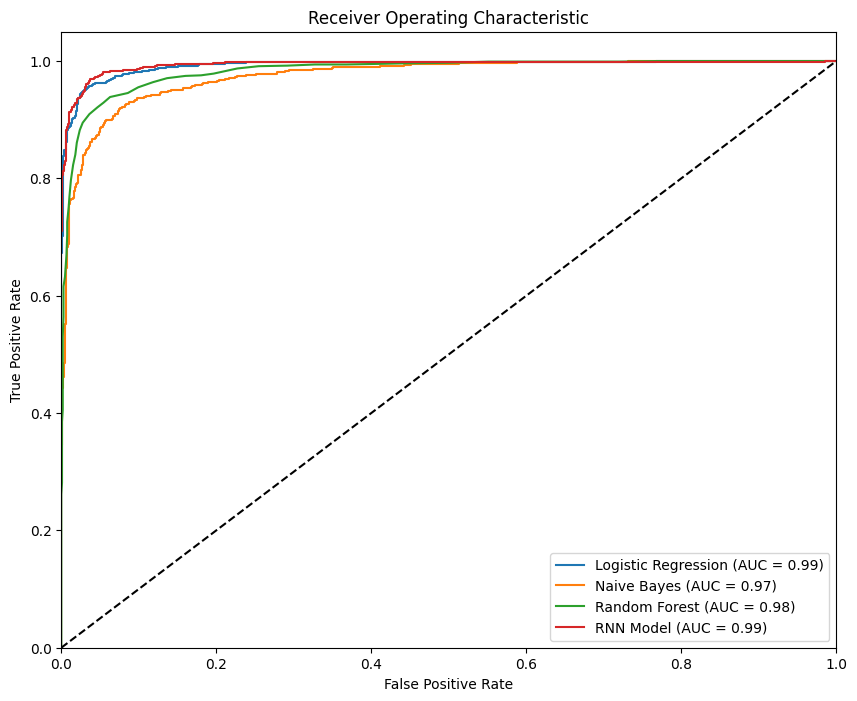

In [15]:
def plot_roc(model, X, y, model_name):
    y_pred_prob = model.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))
plot_roc(logreg_model, X_test_tfidf, y_test, 'Logistic Regression')
plot_roc(naivebayes_model, X_test_tfidf, y_test, 'Naive Bayes')
plot_roc(randomforest_model, X_test_tfidf, y_test, 'Random Forest')

# RNN Model
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, pred_test)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)
plt.plot(fpr_rnn, tpr_rnn, label=f'RNN Model (AUC = {roc_auc_rnn:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for reference
plt.xlim([0.0, 1.0])  # limit for x-axis
plt.ylim([0.0, 1.05])  # limit for y-axis
plt.xlabel('False Positive Rate')  # label for x-axis
plt.ylabel('True Positive Rate')  # label for y-axis
plt.title('Receiver Operating Characteristic')  # plot title
plt.legend(loc="lower right")  # position the legend
plt.show()  # display the plot


**Performance Summary**

In this study, we evaluated the performance of four different models: Logistic Regression, Naive Bayes, Random Forest, and Recurrent Neural Network (RNN) on a binary classification task. We split our data into training, validation, and testing sets and recorded their performances in terms of Accuracy, Precision, Recall, and F1-Score.

The Logistic Regression model performed excellently, achieving perfect scores on the training data. It maintained a high level of performance on the validation and testing data, achieving over 0.95 on all metrics. This suggests that the model was able to generalize well to unseen data and made an excellent balance between precision and recall.

The Naive Bayes model had a lower performance compared to the other models, particularly in terms of recall. While it achieved high precision, its lower recall and F1-scores suggest that it had a higher rate of false negatives. This might be due to the assumptions of Naive Bayes, which might not fully hold in our data.

The Random Forest model also achieved perfect scores on the training data, indicating that it could perfectly fit the training data. On the validation and testing data, it had slightly lower recall compared to precision, but it still achieved over 0.90 on all metrics.

The Recurrent Neural Network (RNN) model performed exceptionally well on all metrics. Even though it didn't reach perfect scores on the training data, it achieved the highest recall on the testing data among all models, suggesting that it was particularly good at minimizing false negatives. Its high precision and F1-scores further suggest that it was excellent at making correct predictions and balancing precision and recall.

In summary, while all models performed well, the RNN model stood out in terms of its ability to balance precision and recall, particularly on the test data. It suggests that for this particular problem, leveraging temporal information with RNNs can lead to better performance. Nevertheless, the choice of model should also consider other factors such as interpretability and computational efficiency. The simpler models such as Logistic Regression and Random Forest also demonstrated excellent performance and could be preferred depending on the specific requirements of the task.




